<a id='top'></a><a name='top'></a>
# Custom TFX Component: Pipeline creation

1. [Introduction](#1.0)
2. [Setup](#2.0)
    * [2.1 Installation and imports](#2.1)
    * [2.2 Setup project structure](#2.2)
    * [2.3 Download dataset](#2.3)
    * [2.4 Create smaller dataset](#2.4)
    * [2.5 Quick examination of data](#2.5)
3. [Create InteractiveContext](#3.0)
4. [Data ingestion](#4.0)
   * [4.1 ExampleGen](#4.1)
        - [4.1.1 Helper functions](#4.1.1)
        - [4.1.2 Overwrite component executor](#4.1.2)
        - [4.1.3 Hook into TFX pipeline workflow](#4.1.3)
5. [Data validation](#5.0)
    * [5.1 StatisticsGen](#5.1)
    * [5.2 SchemaGen](#5.2)
    * [5.3 ExampleValidator](#5.3)
6. [Data preprocessing](#6.0)
    * [6.1 Transform](#6.1)
7. [Model training](#7.0)
    * [7.1 Trainer](#7.1)
    * [7.2 Model export and signature functions](#7.2)
8. [Model analysis and validation](#8.0)
    * [8.1 Resolver](#8.1)
    * [8.2 Evaluator](#8.2)
    * [8.3 Pusher](#8.3)
9. [Export and use with Apache Beam Orchestrator](#9.0)

---
<a name='1.0'></a><a id='1.0'></a>
# 1. Introduction
<a href="#top">[back to top]</a>

Adapted from [Workshop - Developing TensorFlow Extended Components](https://colab.research.google.com/drive/1Z22WiON0NQwjJF-FCy_booVnRxx8-4Lh#scrollTo=fAlDXeya7f-a)

---
<a name='2.0'></a><a id='2.0'></a>
# 2. Setup
<a href="#top">[back to top]</a>

<a name="2.1"></a>
## 2.1 Installation and imports
<a href="#top">[back to top]</a>

In [1]:
# Enable use of %%skip_for_export
%load_ext tfx.orchestration.experimental.interactive.notebook_extensions.skip

In [2]:
%%skip_for_export
# If you want to start with a clean setup
!rm -fr data
!rm -fr pipeline_data
!rm -fr pipeline_output

This cell will be skipped during export to pipeline.


In [3]:
%%skip_for_export
import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("Running on Colab. Installing TFX.")
    !pip install tfx==1.9.1 &> /dev/null
    !pip install python-snappy &> /dev/null
    !pip install watermark -q &> /dev/null
    !apt-get install tree &> /dev/null
    print("You need to restart the Colab runtime after installing TFX:")
else:
    print("Running locally.")

Running locally.
This cell will be skipped during export to pipeline.


In [4]:
# stdlib import
import fnmatch
import os
import os.path
import random
import sys
from typing import Any, Dict, List, Text
import shlex
import subprocess


# third-party imports
from absl import logging
import apache_beam as beam
import pathlib
from pathlib import Path
import tensorflow as tf
import tensorflow_model_analysis as tfma
from tfx import v1 as tfx
from tfx.dsl.components.base import executor_spec # Need for BeamExecutorSpec
from tfx.orchestration import pipeline # Use for exported pipeline with Apache Beam
from tfx.orchestration import metadata # Use for exported pipeline with Apache Beam
from tfx.orchestration.beam.beam_dag_runner import BeamDagRunner # Use for exported pipeline with Apache Beam
from tfx.orchestration.experimental.interactive.interactive_context import InteractiveContext
from tfx.proto import pusher_pb2
from tfx.proto import trainer_pb2
from tfx.proto import example_gen_pb2
from tfx.components.example_gen.base_example_gen_executor import BaseExampleGenExecutor
from tfx.components.example_gen.component import FileBasedExampleGen
from tfx import types
from watermark import watermark

# Need to define again, if restarted runtime on Colab
IN_COLAB = 'google.colab' in sys.modules
%load_ext tfx.orchestration.experimental.interactive.notebook_extensions.skip

# Logging setup
tf.get_logger().propagate = False
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel('ERROR') # DEBUG, INFO, WARN, ERROR, or FATAL
# logging.set_verbosity(logging.ERROR)

def HR():
    print('-'*40)
    
RUN_NOTEBOOK=True

HR()
print("VERSION CHECK:")
print()
print(watermark(packages="tfx,tensorflow,apache_beam", python=True,machine=True,hostname=True))

2022-11-08 14:20:06.471295: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


The tfx.orchestration.experimental.interactive.notebook_extensions.skip extension is already loaded. To reload it, use:
  %reload_ext tfx.orchestration.experimental.interactive.notebook_extensions.skip
----------------------------------------
VERSION CHECK:

Python implementation: CPython
Python version       : 3.8.12
IPython version      : 7.34.0

tfx        : 1.9.1
tensorflow : 2.10.0
apache_beam: 2.39.0

Compiler    : Clang 13.0.0 (clang-1300.0.29.3)
OS          : Darwin
Release     : 21.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

Hostname: Georges-MacBook-Air.local



<a name="2.2"></a>
## 2.2 Setup project structure
<a href="#top">[back to top]</a>

In [5]:
# Setup pathway for project data
print("DATA CONFIG\n")

DATA_ROOT = Path('pipeline_data').as_posix()
DATA_URL = 'https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip'
DATA_SRC = Path(DATA_ROOT).as_posix()
DATA_FILE = "data.zip"
DATA_PATH = Path(DATA_ROOT, DATA_FILE).as_posix()

print(
f"""DATA_ROOT: {DATA_ROOT}
DATA_URL: {DATA_URL}
DATA_SRC: {DATA_SRC}
DATA_FILE: {DATA_FILE}
DATA_PATH: {DATA_PATH}""")
HR()

DATA CONFIG

DATA_ROOT: pipeline_data
DATA_URL: https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
DATA_SRC: pipeline_data
DATA_FILE: data.zip
DATA_PATH: pipeline_data/data.zip
----------------------------------------


In [6]:
print("PIPELINE CONFIG\n")

# Setup pathways for pipeline 1: TFX artifact and metadata output
OUTPUT_ROOT = 'pipeline_output'
PIPELINE_NAME = 'dogs_cats_pipeline'
PIPELINE_ROOT = Path(OUTPUT_ROOT, 'tfx_pipeline_output', PIPELINE_NAME).as_posix()
METADATA_PATH = Path(OUTPUT_ROOT, 'tfx_metadata', PIPELINE_NAME, 'metadata.db').as_posix()

# Need absolute path for TensorFlow Serving
SERVING_MODEL_DIR = Path(OUTPUT_ROOT, 'tfx_serving_model', PIPELINE_NAME).resolve().as_posix()

#_serving_model_dir = f"{DATA_ROOT}/exported_model"
#_serving_model_dir = SERVING_MODEL_DIR

print(
f"""OUTPUT_ROOT: {OUTPUT_ROOT}
PIPELINE_NAME: {PIPELINE_NAME}
PIPELINE_ROOT: {PIPELINE_ROOT}
METADATA_PATH: {METADATA_PATH}
SERVING_MODEL_DIR: {SERVING_MODEL_DIR}""")
HR()

PIPELINE CONFIG

OUTPUT_ROOT: pipeline_output
PIPELINE_NAME: dogs_cats_pipeline
PIPELINE_ROOT: pipeline_output/tfx_pipeline_output/dogs_cats_pipeline
METADATA_PATH: pipeline_output/tfx_metadata/dogs_cats_pipeline/metadata.db
SERVING_MODEL_DIR: /Users/gb/Desktop/TFX-CUSTOM-COMPONENTS/custom-components-ok/pipeline_output/tfx_serving_model/dogs_cats_pipeline
----------------------------------------


<a name="2.3"></a>
## 2.3 Download dataset
<a href="#top">[back to top]</a>

In [7]:
cat_dir=f"{DATA_ROOT}/PetImages/Cat"
dog_dir=f"{DATA_ROOT}/PetImages/Dog"
    
def download_data():
    try:
        Path(DATA_ROOT).mkdir(parents=True, exist_ok=True)
        path_to_downloaded_file = tf.keras.utils.get_file(
            fname=DATA_FILE,
            origin=DATA_URL,
            cache_dir=DATA_SRC,
            cache_subdir=""
        )
        print(f"Downloaded {DATA_URL} to {DATA_SRC}")  
    except Exception as e:
        print(f"Error: {e}")
        
def unzip_download():
    cmd_unzip=f"""unzip -o -q -d {DATA_ROOT} {DATA_ROOT}/{DATA_FILE}"""
    # Wait for command to complete, then return a CompletedProcess instance.
    proc_unzip = subprocess.run(shlex.split(cmd_unzip), stdout = subprocess.PIPE, stderr = subprocess.PIPE)
    print("Finished unzipping download")
    
def dir_files_n(dir_path):
    count = len(fnmatch.filter(os.listdir(dir_path), '*.*'))
    return count

<a name="2.4"></a>
## 2.4 Create smaller dataset
<a href="#top">[back to top]</a>

In [8]:
def reduce_images():
    cat_img_n = dir_files_n(cat_dir)
    print(f"Number of files in {cat_dir}: {cat_img_n}")
    HR()
    
    dog_img_n = dir_files_n(dog_dir)
    print(f"Number of files in {dog_dir}: {dog_img_n}")
    HR()
    
    # Number of images to keep
    REDUCED_SET = 1000
    #REDUCED_SET = 500
    #REDUCED_SET = 6000
    
    
    if cat_img_n > REDUCED_SET:
        print(f"Reduce images in {cat_dir} for demo purposes")
        for filename in sorted(os.listdir(cat_dir))[:-REDUCED_SET]:
            filename_relPath_1 = os.path.join(cat_dir,filename)
            os.remove(filename_relPath_1)
        cat_img_n = dir_files_n(cat_dir)
        print(f"Number of files in {cat_dir}: {cat_img_n}")
        HR()
        
    if dog_img_n > REDUCED_SET:
        print(f"Reduce images in {dog_dir} for demo purposes")
        for filename in sorted(os.listdir(dog_dir))[:-REDUCED_SET]:
            filename_relPath_2 = os.path.join(dog_dir,filename)
            os.remove(filename_relPath_2)
        dog_img_n = dir_files_n(dog_dir)
        print(f"Number of files in {dog_dir}: {dog_img_n}")
        HR()

In [9]:
isdir = os.path.isdir(DATA_ROOT)

if not isdir:
    print("Data does not exist, downloading now..")
    download_data()
    unzip_download()
    reduce_images()

Data does not exist, downloading now..
824887076/824887076 [==============================] - 1286s 2us/step
Downloaded https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip to pipeline_data
Finished unzipping download
Number of files in pipeline_data/PetImages/Cat: 12501
----------------------------------------
Number of files in pipeline_data/PetImages/Dog: 12501
----------------------------------------
Reduce images in pipeline_data/PetImages/Cat for demo purposes
Number of files in pipeline_data/PetImages/Cat: 1000
----------------------------------------
Reduce images in pipeline_data/PetImages/Dog for demo purposes
Number of files in pipeline_data/PetImages/Dog: 1000
----------------------------------------


<a name="2.5"></a>
## 2.5 Quick examination of data
<a href="#top">[back to top]</a>

pipeline_data/PetImages/Cat/9733.jpg


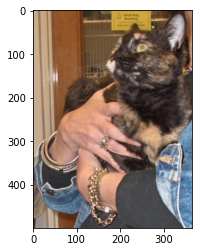

pipeline_data/PetImages/Dog/9733.jpg


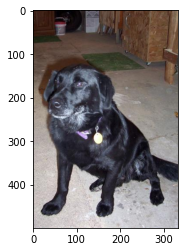

This cell will be skipped during export to pipeline.


In [10]:
%%skip_for_export
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def show_img(img_dir):
    scan = os.scandir(img_dir)
    test = next(scan)
    img = f"{img_dir}/{test.name}"
    print(img)
    display = Image.open(img, "r")
    plt.imshow(np.array(display))
    plt.show()
    
show_img(cat_dir)
show_img(dog_dir)

---
<a name='3.0'></a><a id='3.0'></a>
# 3. Create InteractiveContext
<a href="#top">[back to top]</a>

Create a pipeline for interactive TFX notebook development.

For experimentation with TFX pipeline (such as here), it can be easier to use notebooks. In this experimentation setting, the user manually running the notebook cells is the orchestrator. We use the `InteractiveContext` tool, which manages component execution and state in the notebook.

Basic concepts:

* To create an InteractiveContext, we call `context = InteractiveContext()`. This  manages component execution and state in the notebook. Default parameters use a temporary directory with an ephemeral ML Metadata database instance. We can also specify our own pipeline root or database by passing  the optional properties `pipeline_root` and `metadata_connection_config`
 
```python
context = InteractiveContext(
    pipeline_root=PIPELINE_ROOT,
    pipeline_name=PIPELINE_NAME,
    metadata_connection_config=tfx_metadata
)
```

* To run the component, we call `context.run()` and run that cell.

```python
context.run(statistics_gen)
```

* To use built-in TFX visualization tools, we call `context.show()`. For example, to  review statistics with a built-in TFX visualization:

```python
context.show(statistics_gen.outputs['statistics'])
```



Note:

If we use sqlite format for `metadata_connection_config`, we can easily examine the .db file with an external tool such as "DB Browser for SQLite Version", etc

Resources:

* https://github.com/tensorflow/tfx/blob/0422c4e4017fcc8a671ded67d8954b4a0f11edf4/tfx/orchestration/experimental/interactive/interactive_context.py#L72


In [11]:
%%skip_for_export
tfx_metadata=tfx.orchestration.metadata.sqlite_metadata_connection_config(
    METADATA_PATH
)

# At this point, this only creates the directories. 
# Still haven't created the datastore.
context = InteractiveContext(
    pipeline_root=PIPELINE_ROOT,
    pipeline_name=PIPELINE_NAME,
    metadata_connection_config=tfx_metadata
)

This cell will be skipped during export to pipeline.


In [12]:
%%skip_for_export
# Check new artifacts in pipeline directory
!tree {OUTPUT_ROOT}

pipeline_output
└── tfx_metadata
    └── dogs_cats_pipeline

2 directories, 0 files
This cell will be skipped during export to pipeline.


In [13]:
%%skip_for_export
# Check new artifacts in pipeline directory
!tree {PIPELINE_ROOT}

pipeline_output/tfx_pipeline_output/dogs_cats_pipeline  [error opening dir]

0 directories, 0 files
This cell will be skipped during export to pipeline.


---
<a name='4.0'></a><a id='4.0'></a>
# 4. Data ingestion 
<a href="#top">[back to top]</a>

<a name='4.1'><a id='4.1'></a>
## 4.1 Custom TFX component for ingesting images
<a href="#top">[back to top]</a>

Create a customized FileBasedExampleGen
    
* https://github.com/tensorflow/tfx/blob/master/tfx/components/example_gen/component.py#L116

<a name='4.1.1'><a id='4.1.1'></a>
### 4.1.1 Helper functions
<a href="#top">[back to top]</a>

In [14]:
%%skip_for_export
%%writefile "tfx_helpers.py"
import tensorflow as tf

# Utilities to create a TF-Record binary file, using TF-Example proto format.

def _int64_feature(value):
    """Wrapper for inserting int64 features into Example proto."""
    if not isinstance(value, list):
        value = [value]
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

def _bytes_feature(value):
    """Wrapper for inserting bytes features into Example proto."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def get_label_from_filename(filename):
    """Function to set the label for each image. Here, use the file
    path of a label indicator. This is based on the initial data.
    
    Args:
        filename: string, full file path
    Returns:
        int - label
    Raises:
        NotImplementedError if not label category was detected
    """
    lowered_filename = filename.lower()
    if "dog" in lowered_filename:
        label = 0
    elif "cat" in lowered_filename:
        label = 1
    else:
        raise NotImplementedError("Found unknown image")
    return label

def _convert_to_example(image_buffer, label):
    """Function to convert image byte strings and labels into tf.Example structure
        Args:
            image_buffer: byte string representing the image
            label: int
        Returns:
            TFExample data structure containing the image (byte string) and the label (int encoded)
        """
    example = tf.train.Example(
        features = tf.train.Features(
            feature={
                'image/raw': _bytes_feature(image_buffer),
                'label': _int64_feature(label)
            }
        )
    )
    return example
    
def get_image_data(filename):
    """Process a single image file
    Args:
        filename: string, path to an image, eg '/path/to/example.JPG'.
    Returns:
        TFExample data structure containing the image (byte string) and the label (int encoded)
    """
    label = get_label_from_filename(filename)
    byte_content = tf.io.read_file(filename)
    rs = _convert_to_example(byte_content.numpy(), label)
    return rs

Overwriting tfx_helpers.py
This cell will be skipped during export to pipeline.


<a name='4.1.2'><a id='4.1.2'></a>
### 4.1.2 Overwrite component executor
<a href="#top">[back to top]</a>

Implement a custom component by overwriting the component executor

In [15]:
@beam.ptransform_fn
def ImageToExample(
    pipeline: beam.Pipeline,
    input_dict: Dict[Text, List[types.Artifact]],
    exec_properties: Dict[Text, Any]
) -> beam.pvalue.PCollection:
    """Read jpeg files and transform to TF examples.
    
    Note that each input split will be transformed by this function separately.
    
    Args:
        pipeline: beam pipeline.
        input_dict: Input dict from input key to a list of Artifacts.
        input_base: Input dir that contains the image data.
        exec_properties: A dict of execution properties.
        
    Returns:
        PCollection of TF examples.
    """
    
    # Bug? When run as an exported Python file in Apache Beam, the utilities in
    # helper.py are not accessible within this decorated function, so we import directly.
    from tfx_helpers import _int64_feature
    from tfx_helpers import _bytes_feature
    from tfx_helpers import get_label_from_filename
    from tfx_helpers import _convert_to_example
    from tfx_helpers import get_image_data
    
    image_pattern = os.path.join(input_dict['input_base'], exec_properties)

    logging.info('Processing input image data {} to TFExample.'.format(image_pattern))
    
    image_files = tf.io.gfile.glob(image_pattern)
    
    if not image_files:
    #if not image_files:
        raise RuntimeError(
            'Split pattern {} does not match any files.'.format(image_pattern)
        )
    return (
        pipeline
        | beam.Create(image_files)
        | 'ConvertImagesToBase64' >> beam.Map(lambda file: get_image_data(file))
    )

In [16]:
class ImageExampleGenExecutor(BaseExampleGenExecutor):
    """TFX example gen executor for processing jpeg format
    
    Example usage:
    
        from tfx.components.example_gen.component import FileBasedExampleGen
        
        example_gen = FileBasedExampleGen(
            input_base="./data/PetImages/",
            input_config=input_config,
            output_config=output,
            custom_executor_spec=executor_spec.BeamExecutorSpec(_Executor)
        )
    """
    
    def GetInputSourceToExamplePTransform(self) -> beam.PTransform:
        """Returns PTransform for image to TF examples."""
        return ImageToExample

<a name='4.1.3'><a id='4.1.3'></a>
### 4.1.3 Hook into TFX pipeline workflow
<a href="#top">[back to top]</a>

Overwrite the component executor of FileBasedExampleGen. This creates our customized example_gen TFX component.

In [17]:
# Hook-up customized component into TFX framework
input_config = example_gen_pb2.Input(splits=[
    example_gen_pb2.Input.Split(
        name='images',
        pattern='*/*.jpg'
    )
])

output = example_gen_pb2.Output(
    split_config=example_gen_pb2.SplitConfig(splits=[
        example_gen_pb2.SplitConfig.Split(name='train', hash_buckets=4),
        example_gen_pb2.SplitConfig.Split(name='eval', hash_buckets=1)
    ])
)

example_gen = FileBasedExampleGen(
    input_base=f"{DATA_ROOT}/PetImages",
    input_config=input_config,
    output_config=output,
    
    # Override the executor to add the specific functionality
    custom_executor_spec=executor_spec.BeamExecutorSpec(ImageExampleGenExecutor)
)

In [18]:
%%skip_for_export
context.run(example_gen)

2022-11-08 14:42:28.884830: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


ExecutionResult(
    component_id: FileBasedExampleGen
    execution_id: 1
    outputs:
        examples: OutputChannel(artifact_type=Examples, producer_component_id=FileBasedExampleGen, output_key=examples, additional_properties={}, additional_custom_properties={}))

This cell will be skipped during export to pipeline.


In [19]:
%%skip_for_export
# Check new artifacts in pipeline directory
!tree {PIPELINE_ROOT}

pipeline_output/tfx_pipeline_output/dogs_cats_pipeline
└── FileBasedExampleGen
    └── examples
        └── 1
            ├── Split-eval
            │   └── data_tfrecord-00000-of-00001.gz
            └── Split-train
                └── data_tfrecord-00000-of-00001.gz

5 directories, 2 files
This cell will be skipped during export to pipeline.


In [20]:
%%skip_for_export
context.show(example_gen)

FileBasedExampleGen(spec: <tfx.types.standard_component_specs.FileBasedExampleGenSpec object at 0x1460cb670>, executor_spec: <tfx.dsl.components.base.executor_spec.BeamExecutorSpec object at 0x1460cbac0>, driver_class: <class 'tfx.components.example_gen.driver.FileBasedDriver'>, component_id: FileBasedExampleGen, inputs: {}, outputs: {'examples': OutputChannel(artifact_type=Examples, producer_component_id=FileBasedExampleGen, output_key=examples, additional_properties={}, additional_custom_properties={})})

This cell will be skipped during export to pipeline.


---
<a id='5.0'></a><a name='5.0'></a>
# 5. Data validation
<a href="#top">[back to top]</a>

<a name='5.1'></a><a id='5.1'></a>
## 5.1 StatisticsGen
<a href="#top">[back to top]</a>

The StatisticsGen component generates features statistics and random samples over both training and serving data, which can be used for visualization and validation. StatisticsGen uses Apache Beam and approximate algorithms to scale to large datasets.

Resources:

* https://www.tensorflow.org/tfx/api_docs/python/tfx/v1/components/StatisticsGen

In [21]:
statistics_gen = tfx.components.StatisticsGen(
    examples=example_gen.outputs['examples']
)

In [22]:
%%skip_for_export
context.run(statistics_gen)

ExecutionResult(
    component_id: StatisticsGen
    execution_id: 2
    outputs:
        statistics: OutputChannel(artifact_type=ExampleStatistics, producer_component_id=StatisticsGen, output_key=statistics, additional_properties={}, additional_custom_properties={}))

This cell will be skipped during export to pipeline.


In [23]:
%%skip_for_export
!tree {PIPELINE_ROOT}/StatisticsGen

pipeline_output/tfx_pipeline_output/dogs_cats_pipeline/StatisticsGen
└── statistics
    └── 2
        ├── Split-eval
        │   └── FeatureStats.pb
        └── Split-train
            └── FeatureStats.pb

4 directories, 2 files
This cell will be skipped during export to pipeline.


In [24]:
%%skip_for_export
# Visualize the outputted statistics of StatisticsGen
context.show(statistics_gen.outputs['statistics'])

This cell will be skipped during export to pipeline.


<a name='5.2'></a><a id='5.2'></a>
## 5.2 SchemaGen
<a href="#top">[back to top]</a>

The SchemaGen component uses TensorFlow Data Validation to generate a 
schema from input statistics. The following TFX libraries use this schema:

* TensorFlow Data Validation
* TensorFlow Transform
* TensorFlow Model Analysis

Resources:

* https://www.tensorflow.org/tfx/guide/schemagen

In [25]:
schema_gen = tfx.components.SchemaGen(
    statistics=statistics_gen.outputs['statistics'],
    infer_feature_shape=True
)

In [26]:
%%skip_for_export
context.run(schema_gen)

ExecutionResult(
    component_id: SchemaGen
    execution_id: 3
    outputs:
        schema: OutputChannel(artifact_type=Schema, producer_component_id=SchemaGen, output_key=schema, additional_properties={}, additional_custom_properties={}))

This cell will be skipped during export to pipeline.


In [27]:
%%skip_for_export
# Check new artifacts in pipeline/../SchemaGen
!tree {PIPELINE_ROOT}/SchemaGen

pipeline_output/tfx_pipeline_output/dogs_cats_pipeline/SchemaGen
└── schema
    └── 3
        └── schema.pbtxt

2 directories, 1 file
This cell will be skipped during export to pipeline.


In [28]:
%%skip_for_export
context.show(schema_gen.outputs['schema'])

,Type,Presence,Valency,Domain
Feature name,,,,
'image/raw',BYTES,required,,-
'label',INT,required,,-


This cell will be skipped during export to pipeline.


<a name='5.3'></a><a id='5.3'></a>
## 5.3. ExampleValidator
<a href="#top">[back to top]</a>

The ExampleValidator pipeline component identifies anomalies in training and serving data. It can detect different classes of anomalies in the data.

Resources: 

* https://www.tensorflow.org/tfx/guide/exampleval

In [29]:
example_validator = tfx.components.ExampleValidator(
    statistics=statistics_gen.outputs['statistics'],
    schema=schema_gen.outputs['schema']
)

In [30]:
%%skip_for_export
context.run(example_validator)

ExecutionResult(
    component_id: ExampleValidator
    execution_id: 4
    outputs:
        anomalies: OutputChannel(artifact_type=ExampleAnomalies, producer_component_id=ExampleValidator, output_key=anomalies, additional_properties={}, additional_custom_properties={}))

This cell will be skipped during export to pipeline.


In [31]:
%%skip_for_export
# Check new artifacts in pipeline/../ExampleValidator
!tree {PIPELINE_ROOT}/ExampleValidator

pipeline_output/tfx_pipeline_output/dogs_cats_pipeline/ExampleValidator
└── anomalies
    └── 4
        ├── Split-eval
        │   └── SchemaDiff.pb
        └── Split-train
            └── SchemaDiff.pb

4 directories, 2 files
This cell will be skipped during export to pipeline.


In [32]:
%%skip_for_export
context.show(example_validator.outputs['anomalies'])

This cell will be skipped during export to pipeline.


---
<a name='6.0'></a><a id='6.0'></a>
# 6. Data preprocessing
<a href="#top">[back to top]</a>

Note that we are including the Transform code in the file `tfx_transform.py`

<a name='6.1'></a><a id='6.1'></a>
## 6.1 Transform
<a href="#top">[back to top]</a>

The Transform component wraps TensorFlow Transform (tf.Transform) to preprocess data in a TFX pipeline. This component will load the preprocessing_fn from input module file, preprocess both 'train' and 'eval' splits of input examples, generate the tf.Transform output, and save both transform function and transformed examples to orchestrator desired locations.

The Transform component can also invoke TFDV to compute statistics on the pre-transform and post-transform data. Invocations of TFDV take an optional StatsOptions object. To configure the StatsOptions object that is passed to TFDV for both pre-transform and post-transform statistics, users can define the optional stats_options_updater_fn within the module file.

* Resources:

https://www.tensorflow.org/tfx/api_docs/python/tfx/v1/components/Transform

In [33]:
%%skip_for_export
%%writefile tfx_constants.py
from typing import Text

def transformed_name(key: Text) -> Text:
    """Generate the name of the transformed feature from original name."""
    return key + '_xf'

# Keys
LABEL_KEY = 'label'
INPUT_KEY = 'image/raw'

# Feature keys
RAW_FEATURE_KEYS = [INPUT_KEY]

# Constants
IMG_SIZE = 160

Overwriting tfx_constants.py
This cell will be skipped during export to pipeline.


In [34]:
%%skip_for_export
%%writefile tfx_transform.py
import tensorflow as tf
import tensorflow_transform as tft
import logging
from typing import Union
from typing import Dict
import tfx_constants as constants
import numpy as np

# https://www.tensorflow.org/api_docs/python/tf/function
# Compiles a function into a callable TensorFlow graph.
@tf.function
def convert_image(raw_image: tf.Tensor) -> tf.Tensor:
    if tf.io.is_jpeg(raw_image):
        image = tf.io.decode_jpeg(raw_image, channels=3)
        image = tf.cast(image, tf.float32)
        image = (image / 127.5) - 1
        image = tf.image.resize(image, [constants.IMG_SIZE, constants.IMG_SIZE])
    else:
        image = tf.constant(np.zeros((constants.IMG_SIZE, constants.IMG_SIZE, 3)), tf.float32)
    return image


def fill_in_missing(x: Union[tf.Tensor, tf.SparseTensor]) -> tf.Tensor:
    """Replace missing values in a SparseTensor
    
    Fills in missing values of `x` with '' or 0, and converts to a dense tensor.
    
    Args:
        x: A `SparseTensor` of rank 2. Its dense shape should have size at most 1
        in the second dimension.
        
    Returns:
        A rank 1 tensor where missing values of `x` have been filled in.
    """
    
    if isinstance(x, tf.sparse.SparseTensor):
        default_value = "" if x.dtype == tf.string else 0
        x = tf.sparse.to_dense(
            tf.SparseTensor(x.indices, x.values, [x.dense_shape[0], 1]),
            default_value
        )
    return tf.squeeze(x, axis=1)
    
def preprocessing_fn(inputs: Dict[str, Union[tf.Tensor, tf.SparseTensor]]) -> Dict[str, tf.Tensor]:
    """tf.transform's callback function for preprocessing inputs."""
    outputs = {}
    
    for key in constants.RAW_FEATURE_KEYS:
        image = fill_in_missing(inputs[key])
        outputs[constants.transformed_name(key)] = tf.map_fn(convert_image, image, dtype=tf.float32)
        
    outputs[constants.transformed_name(constants.LABEL_KEY)] = inputs[constants.LABEL_KEY]
    return outputs


Overwriting tfx_transform.py
This cell will be skipped during export to pipeline.


In [35]:
transform = tfx.components.Transform(
    examples = example_gen.outputs['examples'],
    schema = schema_gen.outputs['schema'],
    module_file = os.path.abspath("tfx_transform.py")
)

In [36]:
%%skip_for_export
context.run(transform)

running bdist_wheel
running build
running build_py
creating build
creating build/lib
copying tfx_constants.py -> build/lib
copying tfx_exported_dogs_cats_pipeline.py -> build/lib
copying tfx_helpers.py -> build/lib
copying tfx_transform.py -> build/lib
copying helpers.py -> build/lib
copying tfx_trainer.py -> build/lib
installing to /var/folders/vb/glk9sq0x22qbdp2r6prn8h600000gn/T/tmp5czwxy23
running install
running install_lib
copying build/lib/tfx_constants.py -> /var/folders/vb/glk9sq0x22qbdp2r6prn8h600000gn/T/tmp5czwxy23
copying build/lib/tfx_exported_dogs_cats_pipeline.py -> /var/folders/vb/glk9sq0x22qbdp2r6prn8h600000gn/T/tmp5czwxy23
copying build/lib/tfx_helpers.py -> /var/folders/vb/glk9sq0x22qbdp2r6prn8h600000gn/T/tmp5czwxy23
copying build/lib/tfx_transform.py -> /var/folders/vb/glk9sq0x22qbdp2r6prn8h600000gn/T/tmp5czwxy23
copying build/lib/helpers.py -> /var/folders/vb/glk9sq0x22qbdp2r6prn8h600000gn/T/tmp5czwxy23
copying build/lib/tfx_trainer.py -> /var/folders/vb/glk9sq0x22q

/Users/gb/Desktop/python-3.8.12/env/lib/python3.8/site-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(


Processing ./pipeline_output/tfx_pipeline_output/dogs_cats_pipeline/_wheels/tfx_user_code_Transform-0.0+d3ced5f662db0450dfbefca6694808da1a7f3dbd67d5c40cf765dfe71bf2f87c-py3-none-any.whl



[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


Processing ./pipeline_output/tfx_pipeline_output/dogs_cats_pipeline/_wheels/tfx_user_code_Transform-0.0+d3ced5f662db0450dfbefca6694808da1a7f3dbd67d5c40cf765dfe71bf2f87c-py3-none-any.whl



[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


Processing ./pipeline_output/tfx_pipeline_output/dogs_cats_pipeline/_wheels/tfx_user_code_Transform-0.0+d3ced5f662db0450dfbefca6694808da1a7f3dbd67d5c40cf765dfe71bf2f87c-py3-none-any.whl



[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


ExecutionResult(
    component_id: Transform
    execution_id: 5
    outputs:
        transform_graph: OutputChannel(artifact_type=TransformGraph, producer_component_id=Transform, output_key=transform_graph, additional_properties={}, additional_custom_properties={})
        transformed_examples: OutputChannel(artifact_type=Examples, producer_component_id=Transform, output_key=transformed_examples, additional_properties={}, additional_custom_properties={})
        updated_analyzer_cache: OutputChannel(artifact_type=TransformCache, producer_component_id=Transform, output_key=updated_analyzer_cache, additional_properties={}, additional_custom_properties={})
        pre_transform_schema: OutputChannel(artifact_type=Schema, producer_component_id=Transform, output_key=pre_transform_schema, additional_properties={}, additional_custom_properties={})
        pre_transform_stats: OutputChannel(artifact_type=ExampleStatistics, producer_component_id=Transform, output_key=pre_transform_stats, additional_properties={}, additional_custom_properties={})
        post_transform_schema: OutputChannel(artifact_type=Schema, producer_component_id=Transform, output_key=post_transform_schema, additional_properties={}, additional_custom_properties={})
        post_transform_stats: OutputChannel(artifact_type=ExampleStatistics, producer_component_id=Transform, output_key=post_transform_stats, additional_properties={}, additional_custom_properties={})
        post_transform_anomalies: OutputChannel(artifact_type=ExampleAnomalies, producer_component_id=Transform, output_key=post_transform_anomalies, additional_properties={}, additional_custom_properties={}))

This cell will be skipped during export to pipeline.


In [37]:
%%skip_for_export
# Check new artifacts in pipeline/../Transform
!tree {PIPELINE_ROOT}/Transform

pipeline_output/tfx_pipeline_output/dogs_cats_pipeline/Transform
├── post_transform_anomalies
│   └── 5
│       └── SchemaDiff.pb
├── post_transform_schema
│   └── 5
│       └── schema.pbtxt
├── post_transform_stats
│   └── 5
│       └── FeatureStats.pb
├── pre_transform_schema
│   └── 5
│       └── schema.pbtxt
├── pre_transform_stats
│   └── 5
│       └── FeatureStats.pb
├── transform_graph
│   └── 5
│       ├── metadata
│       │   └── schema.pbtxt
│       ├── transform_fn
│       │   ├── assets
│       │   ├── saved_model.pb
│       │   └── variables
│       │       ├── variables.data-00000-of-00001
│       │       └── variables.index
│       └── transformed_metadata
│           └── schema.pbtxt
├── transformed_examples
│   └── 5
│       ├── Split-eval
│       │   └── transformed_examples-00000-of-00001.gz
│       └── Split-train
│           └── transformed_examples-00000-of-00001.gz
└── updated_analyzer_cache
    └── 5

23 directories, 12 files
This cell will be skipped during exp

In [38]:
%%skip_for_export
# Examine the transform_graph artifact. It points to a directory containing 3 subdirs.
train_uri = transform.outputs['transform_graph'].get()[0].uri
os.listdir(train_uri)

['transformed_metadata', 'transform_fn', 'metadata']

This cell will be skipped during export to pipeline.


In [39]:
%%skip_for_export
# The transformed_metadata subdir contains the schema of the preprocessed data.
# The transform_fn subdir contains the actual preprocessing graph.
# The metadata subdir contains the schema of the original data.

# Take a look at some transformed examples.

# Get the URI of the output artifact representing the transformed examples, which is a directory.
train_uri = os.path.join(transform.outputs['transformed_examples'].get()[0].uri, 'Split-train')
print(f"train_uri:")
print(train_uri)
HR()

# Get the list of files in this directory (all compressed TFRecord files)
tfrecord_filenames = [os.path.join(train_uri, name) for name in os.listdir(train_uri)]
print("tfrecord_filenames:")
print(tfrecord_filenames)
HR()

# Create a TFRecordDataset to read these files
dataset = tf.data.TFRecordDataset(tfrecord_filenames, compression_type="GZIP")
print("dataset:")
print(dataset)
HR()

for raw_record in dataset.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    for x in example.features.feature:
        print(x)  
    #print(example)

train_uri:
pipeline_output/tfx_pipeline_output/dogs_cats_pipeline/Transform/transformed_examples/5/Split-train
----------------------------------------
tfrecord_filenames:
['pipeline_output/tfx_pipeline_output/dogs_cats_pipeline/Transform/transformed_examples/5/Split-train/transformed_examples-00000-of-00001.gz']
----------------------------------------
dataset:
<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
----------------------------------------
label_xf
image/raw_xf
This cell will be skipped during export to pipeline.


---
<a name='7.0'></a><a id='7.0'></a>
# 7. Model training
<a href="#top">[back to top]</a>

We are including the Model code in the file tfx_trainer.py

<a name='7.1'></a><a id='7.1'></a>
## 7.1 Trainer
<a href="#top">[back to top]</a>

The Trainer component is used to train and eval a model using given inputs and a user-supplied run_fn function.

The key function here is `run_fn()`, which is defined in the previously created file, `/module.py`

The Trainer component will look for a `run_fn()` function in our module file and use the function as an entry point to execute the training process.

The module file needs to be accessible to the Trainer component. If you run
the component in an interactive context, you can simply define the absolute path to the module file and pass it to the component. 

The `run_fn()` function is a generic entry point to the training steps and not tf.Keras specific. It carries out the following steps:

* Loading the training and validation data (or the data generator) 
* Defining the model architecture and compiling the model 
* Training the model
* Exporting the model to be evaluated in the next pipeline step

Resources

* https://www.tensorflow.org/tfx/api_docs/python/tfx/v1/components/Trainer

In [40]:
%%skip_for_export
%%writefile {"tfx_trainer.py"}
from typing import List
from typing import Text
from typing import Dict

import os
import absl
import tensorflow as tf
import tensorflow_transform as tft
from datetime import datetime

from tfx.components.trainer.executor import TrainerFnArgs

import tfx_constants as constants

TRAIN_BATCH_SIZE = 32
EVAL_BATCH_SIZE = 32

def HR():
    print('-'*40)

def _gzip_reader_fn(filenames):
    """Small utility returning a record reader that can read gzipped files."""
    return tf.data.TFRecordDataset(
        filenames,
        compression_type='GZIP'
    )

def _get_label_for_image(model, tf_transform_output):
    """Returns a function that parses a raw byte image and applied TFT."""

    model.tft_layer = tf_transform_output.transform_features_layer()
    
    @tf.function
    def serve_images_fn(image_raw):
        """Returns the output to be used in the serving signature."""
        image_raw = tf.reshape(image_raw, [-1, 1])
        parsed_features = {'image': image_raw}
        transformed_features = model.tft_layer(parsed_features)
        return model(transformed_features)
    
    return serve_images_fn



# Our prediction data-input is processed here.

def _get_serve_tf_examples_fn(model, tf_transform_output):
    """Returns a function that parses a serialized tf.Example and applies TFT."""
    
    # Load the preprocessing graph.
    # This layer is added as an attribute to the model in order to make sure that
    # the model assets are handled correctly when exporting.
    model.tft_layer = tf_transform_output.transform_features_layer()
    
    
    @tf.function
    def serve_tf_examples_fn(serialized_tf_examples):
        """Returns the output to be used in the serving signature."""
        
        feature_spec = tf_transform_output.raw_feature_spec()
        feature_spec.pop(constants.LABEL_KEY)

        # Parse the raw tf.Example records from the request.
        parsed_features = tf.io.parse_example(serialized_tf_examples, feature_spec)
        
        # Apply the preprocessing transformation to raw data.
        transformed_features = model.tft_layer(parsed_features)
        
        # Perform prediction with preprocessed data.
        outputs = model(transformed_features)
        return {"outputs": outputs}
    
        # return model(transformed_features)

    return serve_tf_examples_fn



def _input_fn(file_pattern: List[Text], 
              tf_transform_output: tft.TFTransformOutput, 
              batch_size: int = 32, 
              is_train: bool = False) -> tf.data.Dataset:
    """Generates features and label for tuning/training.

    Args:
      file_pattern: input tfrecord file pattern.
      tf_transform_output: A TFTransformOutput.
      batch_size: representing the number of consecutive elements of returned
        dataset to combine in a single batch

    Returns:
      A dataset that contains (features, indices) tuple where features is a
        dictionary of Tensors, and indices is a single Tensor of label indices.
    """
    transformed_feature_spec = (
        tf_transform_output.transformed_feature_spec().copy())

    dataset = tf.data.experimental.make_batched_features_dataset(
        file_pattern=file_pattern,
        batch_size=batch_size,
        features=transformed_feature_spec,
        reader=_gzip_reader_fn,
        label_key=constants.transformed_name(constants.LABEL_KEY))

    return dataset


def get_model() -> tf.keras.Model:
    """Creates a CNN Keras model based on transfer learning for classifying image data.

    Returns:
      A keras Model.
    """
    img_shape = (constants.IMG_SIZE, constants.IMG_SIZE, 3)

    # Create the base model from the pre-trained model MobileNet V2
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=img_shape,
        include_top=False,
        weights='imagenet'
    )
    
    base_model.trainable = False
    base_model.summary()
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
      
    output = tf.keras.layers.Dense(1)
      
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=img_shape, name=constants.transformed_name(constants.INPUT_KEY)),
        base_model,
        global_average_layer,
        tf.keras.layers.Dropout(0.2),
        output
    ])

    model.compile(
        optimizer=tf.optimizers.RMSprop(learning_rate=0.01),
        loss=tf.losses.BinaryCrossentropy(from_logits=True),
        metrics=[tf.metrics.BinaryAccuracy(name='accuracy')]
    )
    
    model.summary()
      
    return model


def run_fn(fn_args: TrainerFnArgs):
    """Train the model based on given args.

    Args:
      fn_args: Holds args used to train the model as name/value pairs.
    """

    tf_transform_output = tft.TFTransformOutput(fn_args.transform_output)

    train_dataset = _input_fn(fn_args.train_files, tf_transform_output,
                              TRAIN_BATCH_SIZE, is_train = True)
    eval_dataset = _input_fn(fn_args.eval_files, tf_transform_output,
                             EVAL_BATCH_SIZE)

    model = get_model()

    model.fit(
        train_dataset,
        steps_per_epoch=fn_args.train_steps,
        validation_data=eval_dataset,
        validation_steps=fn_args.eval_steps,
        verbose=0
    )

    # Define the model signature, which includes the serving function we will describe later.
    signatures = {
        'serving_default': _get_serve_tf_examples_fn(
                model,
                tf_transform_output
            ).get_concrete_function(
                tf.TensorSpec(
                    shape=[None],
                    dtype=tf.string,
                    name='examples'
                )
            ),

    }
    
    HR()
    print("CHECK")
    print(f"fn_args.serving_model_dir: {fn_args.serving_model_dir}")
    HR()


    model.save(
        fn_args.serving_model_dir, 
        save_format='tf', 
        signatures=signatures
    )


Overwriting tfx_trainer.py
This cell will be skipped during export to pipeline.


In [41]:
trainer = tfx.components.Trainer(
    module_file = os.path.abspath("tfx_trainer.py"),
    examples = transform.outputs["transformed_examples"],
    transform_graph = transform.outputs["transform_graph"],
    schema = schema_gen.outputs["schema"],
    train_args = trainer_pb2.TrainArgs(num_steps=1), # 160
    eval_args = trainer_pb2.EvalArgs(num_steps=1) # 200
)

In [42]:
%%skip_for_export
if RUN_NOTEBOOK:
    context.run(trainer)

running bdist_wheel
running build
running build_py
creating build
creating build/lib
copying tfx_constants.py -> build/lib
copying tfx_exported_dogs_cats_pipeline.py -> build/lib
copying tfx_helpers.py -> build/lib
copying tfx_transform.py -> build/lib
copying helpers.py -> build/lib
copying tfx_trainer.py -> build/lib
installing to /var/folders/vb/glk9sq0x22qbdp2r6prn8h600000gn/T/tmpufcbbegv
running install
running install_lib
copying build/lib/tfx_constants.py -> /var/folders/vb/glk9sq0x22qbdp2r6prn8h600000gn/T/tmpufcbbegv
copying build/lib/tfx_exported_dogs_cats_pipeline.py -> /var/folders/vb/glk9sq0x22qbdp2r6prn8h600000gn/T/tmpufcbbegv
copying build/lib/tfx_helpers.py -> /var/folders/vb/glk9sq0x22qbdp2r6prn8h600000gn/T/tmpufcbbegv
copying build/lib/tfx_transform.py -> /var/folders/vb/glk9sq0x22qbdp2r6prn8h600000gn/T/tmpufcbbegv
copying build/lib/helpers.py -> /var/folders/vb/glk9sq0x22qbdp2r6prn8h600000gn/T/tmpufcbbegv
copying build/lib/tfx_trainer.py -> /var/folders/vb/glk9sq0x22q

/Users/gb/Desktop/python-3.8.12/env/lib/python3.8/site-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(


Processing ./pipeline_output/tfx_pipeline_output/dogs_cats_pipeline/_wheels/tfx_user_code_Trainer-0.0+19c1a2294ee370e55285390e1d0c68661e66aebbc27c13e26bc0212063592845-py3-none-any.whl



[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

2022-11-08 14:44:56.030626: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 4342 of 10000
2022-11-08 14:44:57.237809: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


----------------------------------------
CHECK
fn_args.serving_model_dir: pipeline_output/tfx_pipeline_output/dogs_cats_pipeline/Trainer/model/6/Format-Serving
----------------------------------------


This cell will be skipped during export to pipeline.


In [43]:
!tree {PIPELINE_ROOT}/Trainer

pipeline_output/tfx_pipeline_output/dogs_cats_pipeline/Trainer
├── model
│   └── 6
│       └── Format-Serving
│           ├── assets
│           ├── keras_metadata.pb
│           ├── saved_model.pb
│           └── variables
│               ├── variables.data-00000-of-00001
│               └── variables.index
└── model_run
    └── 6

7 directories, 4 files


<a name='7.2'></a><a id='7.2'></a>
## 7.2 Model export and signature functions
<a href="#top">[back to top]</a>

When we export the model, we combine the preprocessing steps from the previous pipeline component with the trained model, and save the model in TensorFlow's SavedModel format. In the `run_fn` function, we define the model signature and save the model.

```python
signatures = {
    "serving_default": _get_serve_tf_examples_fn(
        model, tf_transform_output
    ).get_concrete_function(
        tf.TensorSpec(shape=[None], dtype=tf.string, name="examples")
    ),
}
```

* The `run_fn` exports the `get_serve_tf_examples_fn` as part of the model signature. 
* When a model has been exported and deployed, every prediction request will pass through the `serve_tf_examples_f()`, as shown here:

```python
# Applying the preprocessing graph to model inputs.
# This is called in the signature of run_fn().
def _get_serve_tf_examples_fn(model, tf_transform_output):
    """Returns a function that parses a serialized tf.Example."""

    # Load the preprocessing graph.
    # This layer is added as an attribute to the model in order to make sure that
    # the model assets are handled correctly when exporting.
    model.tft_layer = tf_transform_output.transform_features_layer()

    @tf.function
    def serve_tf_examples_fn(serialized_tf_examples):
        """Returns the output to be used in the serving signature."""
        
        # Note that the input is specified as tf.Example type, which comes from the client.
        # The client is not sending raw str, int, etc, but serialized tf.Example data.
        
        feature_spec = tf_transform_output.raw_feature_spec()
        feature_spec.pop(LABEL_KEY)
        
        # Parse the raw tf.Example records from the request.
        # Conversely, this implies the HTTP POST request must have its 
        # JSON payload in tf.Example format. 
        parsed_features = tf.io.parse_example(serialized_tf_examples, feature_spec)

        # Apply the preprocessing transformation to raw data.
        transformed_features = model.tft_layer(parsed_features)
    
        # Perform prediction with preprocessed data.
        outputs = model(transformed_features)
        return {"outputs": outputs}

    return serve_tf_examples_fn
```

* With every request, we parse the serialized tf.Example records and apply the preprocessing steps to the raw request data. 
* The model then makes a prediction on the preprocessed data.




**Note that this export tf function creates a tf.Example dependency on the client:**

https://github.com/tensorflow/tfx/issues/1885

---
<a name='8.0'></a><a id='8.0'></a>
# 8. Model analysis and validation
<a href="#top">[back to top]</a>


<a name='8.1'></a><a id='8.1'></a>
## 8.1 Resolver
<a href="#top">[back to top]</a>

Resolver is a special TFX node which handles special artifact resolution logics that will be used as inputs for downstream nodes.

To use Resolver, pass the followings to the Resolver constructor:

* Name of the Resolver instance
* A subclass of ResolverStrategy
* Configs that will be used to construct an instance of ResolverStrategy
* Channels to resolve with their tag, in the form of kwargs

Check:

**This component does not seem to create any artifacts on its own, but it usually used in combination with tfx.components.Evaluator, which does create artifacts.**

Resources:

* https://www.tensorflow.org/tfx/api_docs/python/tfx/v1/dsl/Resolver

In [44]:
# model_resolver = tfx.dsl.Resolver(
#     strategy_class = tfx.dsl.experimental.LatestBlessedModelStrategy,
#     model = tfx.dsl.Channel(type=tfx.types.standard_artifacts.Model),
#     model_blessing = tfx.dsl.Channel(type=tfx.types.standard_artifacts.ModelBlessing)
# )

# Resolver is a special TFX node which handles special artifact resolution 
# logics that will be used as inputs for downstream nodes.
model_resolver = tfx.dsl.Resolver(
      strategy_class = tfx.dsl.experimental.LatestBlessedModelStrategy,
      model = tfx.dsl.Channel(type=tfx.types.standard_artifacts.Model),
      model_blessing = tfx.dsl.Channel(
          type=tfx.types.standard_artifacts.ModelBlessing
      ),
  # Note: .with_id() is a method of tfx.dsl.Resolver. 
  # This replaces the deprecated `instance_name` in TFX 0.30.0
).with_id('latest_blessed_model_resolver')


In [45]:
%%skip_for_export
if RUN_NOTEBOOK:
    context.run(model_resolver)

This cell will be skipped during export to pipeline.


In [46]:
%%skip_for_export
!tree {PIPELINE_ROOT}/Trainer

pipeline_output/tfx_pipeline_output/dogs_cats_pipeline/Trainer
├── model
│   └── 6
│       └── Format-Serving
│           ├── assets
│           ├── keras_metadata.pb
│           ├── saved_model.pb
│           └── variables
│               ├── variables.data-00000-of-00001
│               └── variables.index
└── model_run
    └── 6

7 directories, 4 files
This cell will be skipped during export to pipeline.


In [47]:
%%skip_for_export
model_resolver.id

'latest_blessed_model_resolver'

This cell will be skipped during export to pipeline.


<a name='8.2'></a><a id='8.2'></a>
## 8.2 Evaluator
<a href="#top">[back to top]</a>

A TFX component to evaluate models trained by a TFX Trainer component.

Resources:

* https://www.tensorflow.org/tfx/api_docs/python/tfx/v1/components/Evaluator

In [48]:
eval_config = tfma.EvalConfig(
    model_specs=[
        tfma.ModelSpec(
            signature_name="serving_default",
            label_key="label",
            # preprocessing_function_names=["transform_features"],
        )
    ],
    
    slicing_specs=[
        tfma.SlicingSpec()
    ],
    
    metrics_specs=[
        tfma.MetricsSpec(
            metrics=[
                tfma.MetricConfig(
                    class_name="BinaryAccuracy",
                    threshold=tfma.MetricThreshold(
                        value_threshold=tfma.GenericValueThreshold(
                            # BinaryAccuracy must be over 0.45,  0.65
                            lower_bound={"value": 0.45}
                        ),
                        change_threshold=tfma.GenericChangeThreshold(
                            direction=tfma.MetricDirection.HIGHER_IS_BETTER,
                            # Validate if BinaryAccuracy is at least 0.01 higher than baseline model.
                            absolute={'value': 0.01} # -1e-10
                        )
                    ),
                ),
                tfma.MetricConfig(class_name="ExampleCount"),
                # tfma.MetricConfig(class_name="Precision"),
                # tfma.MetricConfig(class_name="Recall"),
                # tfma.MetricConfig(class_name="AUC"),
            ],
        )
    ],
)


In [49]:
# The Evaluator TFX pipeline component performs deep analysis on the 
# training results for your models.
# Note: This always blesses on first run even if below threshold

evaluator = tfx.components.Evaluator(
    examples=example_gen.outputs["examples"],
    model=trainer.outputs["model"],
    baseline_model=model_resolver.outputs["model"],
    eval_config=eval_config,
)

In [50]:
%%skip_for_export
context.run(evaluator)

ExecutionResult(
    component_id: Evaluator
    execution_id: 8
    outputs:
        evaluation: OutputChannel(artifact_type=ModelEvaluation, producer_component_id=Evaluator, output_key=evaluation, additional_properties={}, additional_custom_properties={})
        blessing: OutputChannel(artifact_type=ModelBlessing, producer_component_id=Evaluator, output_key=blessing, additional_properties={}, additional_custom_properties={}))

This cell will be skipped during export to pipeline.


In [51]:
%%skip_for_export
# Check new artifacts
!tree {PIPELINE_ROOT}/Evaluator

pipeline_output/tfx_pipeline_output/dogs_cats_pipeline/Evaluator
├── blessing
│   └── 8
│       └── BLESSED
└── evaluation
    └── 8
        ├── attributions-00000-of-00001.tfrecord
        ├── eval_config.json
        ├── metrics-00000-of-00001.tfrecord
        ├── plots-00000-of-00001.tfrecord
        └── validations.tfrecord

4 directories, 6 files
This cell will be skipped during export to pipeline.


In [52]:
%%skip_for_export
context.show(evaluator.outputs['evaluation'])

This cell will be skipped during export to pipeline.


In [53]:
%%skip_for_export
# To see the visualization for sliced evaluation metrics, 
# directly call the TensorFlow Model Analysis library.

# Get the TFMA output result path and load the result.
PATH_TO_RESULT = evaluator.outputs['evaluation'].get()[0].uri
tfma_result = tfma.load_eval_result(PATH_TO_RESULT)
tfma_result

EvalResult(slicing_metrics=[((), {'': {'': {'accuracy': {'doubleValue': 0.917475700378418}, 'loss': {'doubleValue': 0.2506409287452698}, 'example_count': {'doubleValue': 412.0}, 'binary_accuracy': {'doubleValue': 0.9174757281553398}}}})], plots=[((), None)], attributions=[((), None)], config=model_specs {
  signature_name: "serving_default"
  label_key: "label"
}
slicing_specs {
}
metrics_specs {
  metrics {
    class_name: "BinaryAccuracy"
    threshold {
      value_threshold {
        lower_bound {
          value: 0.45
        }
      }
    }
  }
  metrics {
    class_name: "ExampleCount"
  }
  model_names: ""
}
, data_location='<user provided PCollection>', file_format='<unknown>', model_location='pipeline_output/tfx_pipeline_output/dogs_cats_pipeline/Trainer/model/6/Format-Serving')

This cell will be skipped during export to pipeline.


In [54]:
%%skip_for_export
blessing_uri = evaluator.outputs['blessing'].get()[0].uri
!ls -l {blessing_uri}

total 0
-rw-r--r--  1 gb  staff  0 Nov  8 14:46 BLESSED
This cell will be skipped during export to pipeline.


In [55]:
%%skip_for_export
# Also verify the success by loading the validation result record.
PATH_TO_RESULT = evaluator.outputs['evaluation'].get()[0].uri
print(tfma.load_validation_result(PATH_TO_RESULT))

validation_ok: true
validation_details {
  slicing_details {
    slicing_spec {
    }
    num_matching_slices: 1
  }
}

This cell will be skipped during export to pipeline.


<a name='8.3'></a><a id='8.3'></a>
## 8.3 Pusher
<a href="#top">[back to top]</a>

The Pusher component is usually at the end of a TFX pipeline. It checks whether a model has passed validation, and if so, exports the model to _serving_model_dir.

In [56]:
# _serving_model_dir = f"{DATA_ROOT}/exported_model"

# The Pusher component is used to push a validated model to a 
# deployment target during model training or re-training.

pusher = tfx.components.Pusher(
    model=trainer.outputs['model'],
    model_blessing=evaluator.outputs['blessing'],
    push_destination=tfx.proto.PushDestination(
        filesystem=tfx.proto.PushDestination.Filesystem(
            base_directory=SERVING_MODEL_DIR
        )
    )
)

In [57]:
%%skip_for_export

context.run(pusher)

ExecutionResult(
    component_id: Pusher
    execution_id: 9
    outputs:
        pushed_model: OutputChannel(artifact_type=PushedModel, producer_component_id=Pusher, output_key=pushed_model, additional_properties={}, additional_custom_properties={}))

This cell will be skipped during export to pipeline.


In [58]:
%%skip_for_export
# The Pusher will export your model in the SavedModel format, which looks like this:
push_uri = pusher.outputs['pushed_model'].get()[0].uri
print(push_uri)
HR()

model = tf.saved_model.load(push_uri)
print(model)
HR()

for item in model.signatures.items():
    #pp.pprint(item)
    print(item)

pipeline_output/tfx_pipeline_output/dogs_cats_pipeline/Pusher/pushed_model/9
----------------------------------------
<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x17f7076d0>
----------------------------------------
('serving_default', <ConcreteFunction signature_wrapper(*, examples) at 0x17EA72730>)
This cell will be skipped during export to pipeline.


In [59]:
%%skip_for_export
!tree {SERVING_MODEL_DIR}

/Users/gb/Desktop/TFX-CUSTOM-COMPONENTS/custom-components-ok/pipeline_output/tfx_serving_model/dogs_cats_pipeline
└── 1667886420
    ├── assets
    ├── keras_metadata.pb
    ├── saved_model.pb
    └── variables
        ├── variables.data-00000-of-00001
        └── variables.index

3 directories, 4 files
This cell will be skipped during export to pipeline.


In [60]:
%%skip_for_export

!tree nb_output2/nb_pipeline_output2/nb_dogs_cats_pipeline2/Pusher/pushed_model/

nb_output2/nb_pipeline_output2/nb_dogs_cats_pipeline2/Pusher/pushed_model/  [error opening dir]

0 directories, 0 files
This cell will be skipped during export to pipeline.


---
<a name='9.0'></a><a id='9.0'></a>
# 9. Export and use with Apache Beam Orchestrator
<a href="#top">[back to top]</a>

In [61]:
_pipeline_name = PIPELINE_NAME
_pipeline_root = PIPELINE_ROOT
_metadata_path = METADATA_PATH

In [62]:
components = [
    example_gen,
    statistics_gen,
    schema_gen,
    example_validator,
    transform,
    trainer,
    model_resolver,
    evaluator,
    pusher,
]

In [67]:
%%skip_for_export
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    notebook_filepath = ('/content/drive/My Drive/Colab Notebooks/02-override-executor.ipynb')
else:
    notebook_filepath = ('custom-tfx-component-pipeline.ipynb')

This cell will be skipped during export to pipeline.


In [68]:
%%skip_for_export
pipeline_export_filepath = 'tfx_exported_{}.py'.format(PIPELINE_NAME)

print(pipeline_export_filepath)

context.export_to_pipeline(
    notebook_filepath=notebook_filepath,
    export_filepath=pipeline_export_filepath,
    runner_type="beam"
)

tfx_exported_dogs_cats_pipeline.py
This cell will be skipped during export to pipeline.


In [69]:
HR()
print("Done...")
HR()

----------------------------------------
Done...
----------------------------------------


In [66]:
# Set up to run python pipeline script on Colab
# 1. Upload files constants.py, exported_pipeline_nb_dogs_cats_pipeline3.py, helpers.py, trainer.py, transform.py
# 2. Create these notebook cells:
################################################
# CELL 1
#
# import sys
# IN_COLAB = 'google.colab' in sys.modules
# if IN_COLAB:
#     print("Running on Colab. Installing TFX.")
#     !pip install tfx==1.9.1 &> /dev/null
#     !apt-get install tree &> /dev/null
#     !pip install python-snappy &> /dev/null
#     !pip install watermark -q &> /dev/null
#     print("You need to restart the Colab runtime after installing TFX:")
# else:
#     print("Running locally.")
################################################
# CELL 2
# !python3 exported_pipeline_nb_dogs_cats_pipeline3.py